### $M/M/s+H_{\theta}$ queueing system
### Arrival rate $\lambda$
### Joining probability $H_{\theta}(p, Q) = e^{-\theta_1 p - \theta_2 (Q-s+1)^{+}}$, admission price = $p$, observed system occupancy (waiting + service) = $Q$
### $R(p) = \lambda p \mathbb{E} \Big(\widetilde{H}_{\theta}(p,Q)\Big)$

In [1]:
import math

import numpy as np

from scipy.optimize import fsolve, minimize, Bounds, LinearConstraint
from scipy.integrate import quad
from scipy import linspace, meshgrid, arange, empty, concatenate, newaxis, shape

import matplotlib.pyplot as plt
from matplotlib import cm

from collections import deque

import time

In [2]:
# Important variables

# True arrival rate
global lam

# True joining probability parameters
global theta_1, theta_2

# Number of servers
global s

# Admission price - what we control
global price

# Stores all prices that we decided
global admission_price_list

# Batchsize - Total non-balking customers in each group
global batch_size

# Cutoff - Steady state distribution trimmed down to certain level
global cutoff

# Total customers that we shall generate
global n

# Learning rate
global gamma

In [3]:
def generate_arrival_process(x): # x is the arrival rate
    global interarrival_times
    global arrival_times
    
    interarrival_times = np.random.exponential(1/x, n)
    arrival_times = np.cumsum(interarrival_times)

In [4]:
def generate_service_times(x): # x is the mean service time
    global service_times
    global mean_service_time
    
    # Gamma distribution - mean = x[0]x[1] and variance = x[0]x[1]^2
    # mean_service_time = x[0]*x[1]
    # service_times = np.random.gamma(x[0], x[1], n)
    
    # Exponential distribution
    mean_service_time = x
    service_times = np.random.exponential(x, n)

In [5]:
class Customer(): # Creating an object "Customer" with relevant information
    # Price paid by customer
    price_paid = 0
    
    # Time of arrival
    t_arrival = 0
    
    # Time of departure
    t_departure = 0
    
    # Time taken for servicing
    t_service = 0
    
    # Time spent waiting in queue (does not include service time)
    t_in_queue = 0
    
    # Server number which served the customer
    server = 0
    
    # Does the customer balk? 0 if yes, 1 if no
    balking = 0
    
    # Customer number (basically assigned between 0 and n-1)
    number = 0
    
    # Observed number of customers in system upon arrival and before joining
    observed_system_occupancy = 0
    
    jump_virtual_waiting_time = 0

In [6]:
def queue_simulation(price):
    
# Idea

# Create array of workload of servers - Workload[s]
# Calculate min workload and server with min workload. If min workload > incoming customer patience, then customer balks. 
# Else, new workload (of min workload server) = current workload + service time of incoming customer
# This array will be updated during every arrival (only based on updated values we can decide balking or not!)
# If customer is non-balking, it is easy to get their waiting time in queue (= min workload amongst all servers)

# Maintain an array of "s" queues, each queue i literally represents queue in front of server i - append and pop customers during each arrival event
# Maintain a list to keep track of residual service times
    
    # Simulation variables
    global customers
    global server_workloads
    global dynamic_queues
    global dynamic_residual_service_times
    
    # Post processing variables
    global n_eff
    global fraction_balking_customers
    global effective_arrival_times
    global effective_interarrival_times
    global departure_times
    global waiting_times
    global upward_jump_virtual_waiting_times
    
    # Plotting variables
    global total_customers_in_system
    global total_workload_in_system
    
    # Virtual waiting time - at time of joining
    global virtual_waiting_time_balking_instances
    global virtual_waiting_time_non_balking_instances
    global estimated_virtual_waiting_time_balking_instances
    global estimated_virtual_waiting_time_non_balking_instances
    
    # Queue length - at time of joining
    global system_size_balking_instances
    global system_size_non_balking_instances
    global price_non_balking_instances
    
    # Other objects to store
    global change_times
    global system_size_just_after_change_times
    global price_just_after_change_times
    global expected_LST
    
    # Plotting purposes
    global revenue_gradient_storage
    
    global estd_pars
    estd_pars = np.array((10, 0.5, 0.5))
    
##################################################################################################################################    
    
    # Initialization
    customers = [Customer() for i in range(n)]
    server_workloads = np.zeros(s)
    
    virtual_waiting_time_balking_instances = []
    virtual_waiting_time_non_balking_instances = []
    
    estimated_virtual_waiting_time_balking_instances = []
    estimated_virtual_waiting_time_non_balking_instances = []
    
    system_size_balking_instances = []
    system_size_non_balking_instances = []
    
    price_non_balking_instances = []

    revenue_gradient_storage = []
    
    # New variables to keep track of
    dynamic_residual_service_times = np.zeros(s) # Keeps track of residual service times just after arrival events during the simulation
    dynamic_queues = [] # Maintains queues corresponding to all s servers
    for i in range(s):
        q = deque()
        dynamic_queues.append(q)

    # Relevant information to calculate and store
    fraction_balking_customers = 0
    effective_arrival_times = []
    effective_interarrival_times = []
    departure_times = []
    waiting_times = []
    upward_jump_virtual_waiting_times = []
    expected_LST = []

    # For graph plotting later
    total_customers_in_system = np.zeros(n) # Just after each arrival, we store --> total customers in system
    total_workload_in_system = np.zeros(n) # Just after each arrival, we store --> total workload in system
    
##################################################################################################################################   
    
    groups = 0 # Counts the number of batches
    group_size = 0 # Counts the number of customers within 1 batch. When this value becomes equal to batch size, we estimate lambda, theta_1, theta_2
    
    i = 0
    for cust in customers:
        # Storing customer information first
        cust.number = i
        cust.t_arrival = arrival_times[i]
        cust.t_service = service_times[i]
        
        # Calculates number in system observed by incoming arrival
        system_size_at_joining_instant = sum(len(dynamic_queues[j]) for j in range(s))
        estimated_virtual_waiting_time = max(0, (system_size_at_joining_instant-s+1)*mean_service_time/s)
        
        joining_probability = np.exp(-theta_1*price -theta_2*max(0, system_size_at_joining_instant-s+1))
        decision = np.random.binomial(1, joining_probability)
        
        min_workload_server = server_workloads.argmin()

        if decision == 0: # Balking customer
            cust.balking = 0 # does not join
            fraction_balking_customers += 1
            virtual_waiting_time_balking_instances.append(server_workloads[min_workload_server])
            system_size_balking_instances.append(system_size_at_joining_instant)
            estimated_virtual_waiting_time_balking_instances.append(estimated_virtual_waiting_time)

        else: # Non-balking customer
            group_size += 1
            
            virtual_waiting_time_non_balking_instances.append(server_workloads[min_workload_server])
            system_size_non_balking_instances.append(system_size_at_joining_instant)
            estimated_virtual_waiting_time_non_balking_instances.append(estimated_virtual_waiting_time)
            
            dynamic_queues[min_workload_server].append(i) # Customer joins queue corresponding to minimum workload server
            if len(dynamic_queues[min_workload_server]) == 1:
                dynamic_residual_service_times[min_workload_server] = cust.t_service

            effective_arrival_times.append(cust.t_arrival)
            price_non_balking_instances.append(price)

            cust.balking = 1 # joins
            cust.server = min_workload_server
            cust.t_in_queue = server_workloads[min_workload_server]
            cust.t_departure = cust.t_arrival + cust.t_in_queue + cust.t_service

            # Jump in virtual waiting time calculation
            cust.jump_virtual_waiting_time -= server_workloads[min_workload_server] # Subtracting virtual waiting time BEFORE customer arrival
            server_workloads[min_workload_server] += cust.t_service # Adds arriving customer's service time to minimum workload server
            min_workload_server = server_workloads.argmin() # Calculates new "minimum workload server"
            cust.jump_virtual_waiting_time += server_workloads[min_workload_server] # Adding new virtual waiting time AFTER customer arrival

            waiting_times.append(cust.t_in_queue)
            departure_times.append(cust.t_departure)
            upward_jump_virtual_waiting_times.append(cust.jump_virtual_waiting_time)
        
        
        total_customers_in_system[i] = sum([len(dynamic_queues[k]) for k in range(s)])
        total_workload_in_system[i] = np.sum(server_workloads)
        
        
        
        if group_size == batch_size:
            # Preprocess data for estimation
            
            groups += 1
            
            change_times = [] # Tracks all arrival and departure times
            change_times.append(0)

            system_size_just_after_change_times = [] # Tracks system size just after above times
            system_size_just_after_change_times.append(0)
            
            price_just_after_change_times = []
            price_just_after_change_times.append(admission_price_list[0])
            
            departure_times.sort()

            index = np.searchsorted(departure_times, cust.t_arrival, side = "left")
            relevant_departure_times = departure_times[0:index]

            # Storing necessary data for Log Likelihood
            arrival_count = 0
            departure_count = 0
            number_in_system = 0 # system size at time 0

            while departure_count < len(relevant_departure_times):
                # print(arrival_count)
                if effective_arrival_times[arrival_count] < relevant_departure_times[departure_count]:
                    change_times.append(effective_arrival_times[arrival_count])
                    arrival_count += 1
                    number_in_system += 1
                    system_size_just_after_change_times.append(number_in_system)
                else:
                    change_times.append(relevant_departure_times[departure_count])
                    departure_count += 1
                    number_in_system -= 1
                    system_size_just_after_change_times.append(number_in_system)
                
                if arrival_count != len(effective_arrival_times):
                    price_index = arrival_count // batch_size
                    # print(price_index)
                    price_just_after_change_times.append(admission_price_list[price_index])
                
            while arrival_count < len(effective_arrival_times):
                change_times.append(effective_arrival_times[arrival_count])
                arrival_count += 1
                number_in_system += 1
                system_size_just_after_change_times.append(number_in_system)
                
                if arrival_count != len(effective_arrival_times):
                    price_index = arrival_count // batch_size
                    # print(price_index)
                    price_just_after_change_times.append(admission_price_list[price_index])
            
            # Arrays NOT required for later use in queue simulation
            change_times = np.array(change_times)
            system_size_just_after_change_times = np.array(system_size_just_after_change_times)
            price_just_after_change_times = np.array(price_just_after_change_times)
            
            # Arrays required for later use in queue simulation
            system_size_non_balking_instances = np.array(system_size_non_balking_instances)
            price_non_balking_instances = np.array(price_non_balking_instances)
            
            
            # Empirical calculation for E[e^{-theta_2(Q-s+1)+}] for batches with the same price
            times = []
            system_size_just_after_times = []
            
            index_start = np.where(change_times == effective_arrival_times[(groups-1)*group_size])[0][0]
            index_end = np.where(change_times == effective_arrival_times[groups*group_size-1])[0][0]
    
            times = change_times[index_start: index_end+1]
            system_size_just_after_times = system_size_just_after_change_times[index_start: index_end+1]
            
            expected_value_1 = np.sum(np.exp(-theta_2*np.maximum(0, system_size_just_after_times[0:-1]-s+1))*(times[1:]-times[0:-1]))/(times[-1] - times[0])
            # Following line calculates empirical LST of (Q-s+1)+ using the entire sample path. It performs poorer than the previous line
            # expected_value_2 = np.sum(np.exp(-theta_2*np.maximum(0, system_size_just_after_change_times[0:-1]-s+1))*(change_times[1:]-change_times[0:-1]))/(change_times[-1] - change_times[0])
            
            expected_LST.append(expected_value_1)
            
            # print("Price = ", price)
            # print("Empirical LST from 1 block = ", expected_LST[-1])
            # print("Empirical LST from entire observation = ", expected_value_2)
            # print("Theoretical LST = ", theoretical_LST([price, lam, theta_1, theta_2]))
            # print("")
            
            # Estimate
            
            initial_estimates = estd_pars
            
            estimates = minimize(Log_Likelihood, initial_estimates, method = "nelder-mead")
            estd_pars = estimates.x
            
            # Update price
            
            gradient = evaluate_derivative_revenue_wrt_price((price, estd_pars[0], estd_pars[1], estd_pars[2]))
            revenue_gradient_storage.append(gradient)
            price = price + (gamma/groups)*gradient

            # price = price + 1
            
            # print("Iteration = ", groups)
            # print("Estimates (lambda, theta_1, theta_2) = ", estimates.x)
            # print("Estimated Log Likelihood = ", -Log_Likelihood(estimates.x))
            # print("True Log Likelihood = ", -Log_Likelihood([lam, theta_1, theta_2]))
            # print("Gradient = ", gradient)
            # print("Updated price for next batch = ", price)
            # print("")
            # print("Price non balking instances = ", np.around(price_non_balking_instances,3))
            # print("Effective arrival times = ", np.around(effective_arrival_times,3))
            # print("Departure times = ", np.around(departure_times,3))
            # print("Relevant departure times = ", np.around(relevant_departure_times,3))
            # print("Change times = ", np.around(change_times,3))
            # print("Admission prices list = ", np.around(admission_prices_list,3))
            # print("Price just after change times = ", np.around(price_just_after_change_times,3))
            # print("System size just after change times = ", np.around(system_size_just_after_change_times,3))
            # print("")
    
            admission_price_list.append(price)
            
            # Reset data for further queue simulation
            system_size_non_balking_instances = np.ndarray.tolist(system_size_non_balking_instances)
            price_non_balking_instances = np.ndarray.tolist(price_non_balking_instances)
            
            group_size = 0
            
        
        if i != n-1:
            # Time to update residual service times here. Mathematical formulation of the code is as follows:-
            # Suppose service times of a queue corresponding to a server are: 5(residual service time of customer being served),20,22,17,23,28,... and time since last arrival is 50,
            # Then, new queue becomes 14,23,28,... 
            for j in range(s):
                if len(dynamic_queues[j]) == 0:
                    dynamic_residual_service_times[j] = 0
                    continue

                time_until_next_arrival = arrival_times[i+1] - arrival_times[i]

                if time_until_next_arrival > dynamic_residual_service_times[j]:
                    time_until_next_arrival -= dynamic_residual_service_times[j]
                    dynamic_residual_service_times[j] = 0
                    dynamic_queues[j].popleft()
                else:
                    dynamic_residual_service_times[j] -= time_until_next_arrival
                    continue

                while len(dynamic_queues[j])!=0 and time_until_next_arrival > customers[dynamic_queues[j][0]].t_service:
                    time_until_next_arrival -= customers[dynamic_queues[j][0]].t_service
                    dynamic_queues[j].popleft()

                if len(dynamic_queues[j]) == 0:
                    dynamic_residual_service_times[j] = 0
                    continue
                else:
                    dynamic_residual_service_times[j] = customers[dynamic_queues[j][0]].t_service - time_until_next_arrival
            
            
            server_workloads -= (arrival_times[i+1] - arrival_times[i]) # Subtracting time passed until next arrival from all server workloads
            server_workloads = np.where(server_workloads < 0, 0, server_workloads)  # All those with workload < 0 are converted to 0
        
        i += 1

##################################################################################################################################
        
    # Post processing    
    n_eff = n - fraction_balking_customers

    fraction_balking_customers /= n

    effective_interarrival_times = [effective_arrival_times[0]] + [j-i for i,j in zip(effective_arrival_times, effective_arrival_times[1:])]
    departure_times.sort()
    effective_arrival_times = np.array(effective_arrival_times)
    effective_interarrival_times = np.array(effective_interarrival_times)
    departure_times = np.array(departure_times)
    waiting_times = np.array(waiting_times)
    upward_jump_virtual_waiting_times = np.array(upward_jump_virtual_waiting_times)
    
    system_size_balking_instances = np.array(system_size_balking_instances)
    system_size_non_balking_instances = np.array(system_size_non_balking_instances)
    
    virtual_waiting_time_balking_instances = np.array(virtual_waiting_time_balking_instances)
    virtual_waiting_time_non_balking_instances = np.array(virtual_waiting_time_non_balking_instances)
    
    estimated_virtual_waiting_time_balking_instances = np.array(estimated_virtual_waiting_time_balking_instances)
    estimated_virtual_waiting_time_non_balking_instances = np.array(estimated_virtual_waiting_time_non_balking_instances)
    
    expected_LST = np.array(expected_LST)
    
    # admission_price_list = np.array(admission_price_list)
    
    return price

In [7]:
def Log_Likelihood(par):
    # par[0] = lambda
    # par[1] = theta_1
    # par[2] = theta_2
    
    # Term 1
    L = len(system_size_non_balking_instances)*np.log(par[0])
    
    # Term 2
    log_H_system_size_non_balking_instances = -par[1]*price_non_balking_instances -par[2]*np.maximum(0, system_size_non_balking_instances-s+1)
    L += np.sum(log_H_system_size_non_balking_instances)
    
    # Term 3
    H_system_size_just_after_change_times = np.exp(-par[1]*price_just_after_change_times -par[2]*np.maximum(0, system_size_just_after_change_times[0:-1]-s+1))
    L -= par[0]*np.sum(H_system_size_just_after_change_times*(change_times[1:]-change_times[0:-1]))
    
    return -L

In [8]:
def evaluate_steady_state_distribution(par):
    # Trims steady state distribution to {p0, p1, p2, ..., p_cutoff}
    
    # given price = par[0]
    # given lambda = par[1]
    # given theta_1 = par[2]
    # given theta_2 = par[3]
    
    global steady_state_distribution
    
    steady_state_distribution = np.ones(cutoff+1)
    for i in range(1, s+1):
        steady_state_distribution[i] = steady_state_distribution[i-1]*par[1]*mean_service_time*np.exp(-par[2]*par[0])/i
    for i in range(s+1, cutoff+1):
        steady_state_distribution[i] = steady_state_distribution[i-1]*par[1]*mean_service_time*np.exp(-par[2]*par[0]-par[3]*(i-s))/s
        
    steady_state_distribution = steady_state_distribution/np.sum(steady_state_distribution)
    
    return steady_state_distribution

In [9]:
def evaluate_derivative_steady_state_distribution_wrt_price(par):
    # given price = par[0]
    # given lambda_ = par[1]
    # given theta_1 = par[2]
    # given theta_2 = par[3]
    
    delta = 1e-6
    
    derivative = (evaluate_steady_state_distribution([par[0]+delta, par[1], par[2], par[3]]) - evaluate_steady_state_distribution(par))/delta
    
    return derivative

In [10]:
def evaluate_derivative_revenue_wrt_price(par):
    # given price = par[0]
    # given lambda = par[1]
    # given theta_1 = par[2]
    # given theta_2 = par[3]
    
    steady_state_distribution = evaluate_steady_state_distribution(par)
    derivative_steady_state_distribution = evaluate_derivative_steady_state_distribution_wrt_price(par)
    
    term_1 = par[1]*np.exp(-par[2]*par[0])*(1-par[2]*par[0])*np.sum(np.exp(-par[3]*np.maximum(0, np.arange(cutoff+1)-s+1))*steady_state_distribution)
    term_2 = par[1]*par[0]*np.exp(-par[2]*par[0])*np.sum(np.exp(-par[3]*np.maximum(0, np.arange(cutoff+1)-s+1))*derivative_steady_state_distribution)

    # print("Term 1 = ", term_1)
    # print("Term 2 = ", term_2)
    
    derivative_revenue = term_1 + term_2
    
    return derivative_revenue

In [11]:
def evaluate_revenue_given_price(par):
    # given price = par[0]
    # given lambda = par[1]
    # given theta_1 = par[2]
    # given theta_2 = par[3]
    
    steady_state_distribution = evaluate_steady_state_distribution(par)
    revenue = par[0] * par[1] * np.exp(-par[2]*par[0]) * np.sum(np.exp(-par[3]*np.maximum(0, np.arange(cutoff+1)-s+1))*steady_state_distribution)
    
    return revenue

In [12]:
def theoretical_LST(par):
    
    steady_state_distribution = evaluate_steady_state_distribution(par)
    
    theoretical_LST = np.sum(np.exp(-par[3]*np.maximum(0, np.arange(cutoff+1)-s+1))*steady_state_distribution)
    
    return theoretical_LST

# Graphically estimating correct price

Optimal price from graph =  15.5
Maximum theoretical revenue =  57.37521918749301


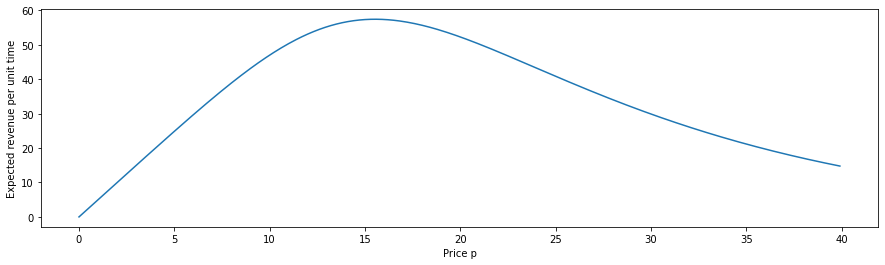

In [13]:
## Recheck SGD for non-concave price function

# Optimal price from true values

global optimal_price_theoretical
global maximum_revenue_theoretical

# True values
lam = 20
theta_1 = 0.1
theta_2 = 0.2
s = 5

mean_service_time = 1
cutoff = 200

# Plotting
prices = np.arange(0, 40, 0.1)

# Theoretical optimal price to charge at the true parameters, and corresponding maximum revenue
optimal_price_theoretical = 0
max_revenue_theoretical = 0

revenues = []
for admission_price in prices:
    revenue_per_unit_time = evaluate_revenue_given_price([admission_price, lam, theta_1, theta_2])
    revenues.append(revenue_per_unit_time)
    if revenue_per_unit_time > max_revenue_theoretical:
        max_revenue_theoretical = revenue_per_unit_time
        optimal_price_theoretical = admission_price

plt.figure(figsize = (15,4))
plt.plot(prices, revenues)
plt.ylabel("Expected revenue per unit time")
plt.xlabel("Price p")

print("Optimal price from graph = ", optimal_price_theoretical)
print("Maximum theoretical revenue = ", max_revenue_theoretical)

In [ ]:
# create a list of tuples using enumerate()
tuples = [(key, value)
          for i, (key, value) in enumerate(zip(prices, revenues))]
 
# convert list of tuples to dictionary using dict()
price_revenue_dict = dict(tuples)

price_revenue_dict[26.5]

In [ ]:
# Optimal price from estimated values

print("Estimated parameters are: ", estd_pars)

mean_service_time = 1

s = 4
cutoff = 200

prices = np.arange(0, 100.1, 0.1)

optimal_price_estimated = 0
max_revenue_estimated = 0

revenues = []
for admission_price in prices:
    revenue_per_unit_time = evaluate_revenue_given_price([admission_price, estd_pars[0], estd_pars[1], estd_pars[2]])
    if revenue_per_unit_time > max_revenue_estimated:
        max_revenue_estimated = revenue_per_unit_time
        optimal_price_estimated = admission_price
    revenues.append(revenue_per_unit_time)

plt.figure(figsize = (15,4))
plt.plot(prices, revenues)
plt.ylabel("Expected revenue per unit time")
plt.xlabel("Price p")

print("Optimal price from graph = ", optimal_price_estimated)
print("Maximum revenue by charging the above price = ", max_revenue_estimated)

## Estimation and Gradient Descent

In [ ]:
# True values
lam = 20
theta_1 = 0.1
theta_2 = 0.2

s = 5
cutoff = 200

# Starting price
price = 5
admission_price_list = []
admission_price_list.append(price)

global estd_pars
estd_pars = np.array((10, 0.5, 0.5))

# Simulation
n = 100000
batch_size = 1000
gamma = 5

generate_arrival_process(lam)
generate_service_times(1)

output_price = queue_simulation(price)

print("Output price = ", output_price)

In [ ]:
true_pars = [optimal_price_theoretical, lam, theta_1, theta_2]

distr_1 = evaluate_steady_state_distribution(true_pars)
distr_2 = evaluate_steady_state_distribution([price, estd_pars[0], estd_pars[1], estd_pars[2]])

print("True distribution = ", distr_1[0:10])
print("Estimated distribution = ", distr_2[0:10])

In [ ]:
# Plot of gradients

plt.figure(figsize = (15,4))
plt.xlabel("Iteration")
plt.ylabel("Gradient of revenue w.r.t. price")
plt.title("Evolution of gradient")

plt.plot(np.arange(1, len(revenue_gradient_storage)+1), revenue_gradient_storage, color = "black")
plt.axhline(0, color = 'r', linestyle = '--')


# Plot of price

plt.figure(figsize = (15,4))
plt.xlabel("Iteration")
plt.ylabel("Price")
plt.title("Evolution of price")
plt.plot(np.arange(1, len(admission_price_list)+1), admission_price_list, color="blue", label="Gradient Descent price iterates")
plt.axhline(optimal_price_theoretical, color = 'red', linestyle = '--', label="Theoretical optimal price")
plt.legend()
plt.savefig("SGD price iterates.pdf")

# Plot of empirical and theoretical LST of (Q-s+1)+

plt.figure(figsize = (15,4))
plt.xlabel("Price")
plt.ylabel("Empirical LST")

plt.scatter(admission_price_list[0:-1], expected_LST)

temp = admission_price_list[0:-1]
temp = np.array(temp)
constants = expected_LST * temp/np.exp(theta_1*temp)
est_const = constants.mean()
print(est_const)

plt.scatter(temp, est_const*np.exp(theta_1*temp)/temp)

In [ ]:
temp = admission_price_list[0:-1]
temp = np.array(temp)

constants = expected_LST * temp/np.exp(theta_1*temp)
print(constants)
print(constants.mean())

In [ ]:
true_const = theoretical_LST([optimal_price_theoretical, lam, theta_1, theta_2])*np.exp(-theta_1*optimal_price_theoretical)*optimal_price_theoretical
print(true_const)

## Obtaining optimal price for $M/G/s + H$ systems

In [ ]:
# How to evaluate optimal prices for other distributions that are not exponential?
# From time average obtained from a simulation

# True values
lam = 50
theta_1 = 0.1
theta_2 = 0.2
s = 4

n = 100000
batch_size = n

# Graph plotting
prices = np.arange(0, 51, 1)
revenues = []

generate_arrival_process(lam)
generate_service_times([0.1, 10])

optimal_price = 0
max_revenue = 0

for admission_price in prices:
    queue_simulation(admission_price)
    
    revenue_per_unit_time = n_eff*admission_price/arrival_times[-1]
    
    if revenue_per_unit_time > max_revenue:
        max_revenue = revenue_per_unit_time
        optimal_price = admission_price
        
    revenues.append(revenue_per_unit_time)

plt.figure(figsize = (15,4))
plt.plot(prices, revenues)
plt.ylabel("Average revenue per unit time from simulation")
plt.xlabel("Price p")

print("Optimal price from graph = ", optimal_price)
print("Maximum estimated price = ", max_revenue)

## Rough Work

In [ ]:
# Values
price = 9
lam = 20
theta_1 = 0.1
theta_2 = 0.2

s = 5
cutoff = 200

mean_service_time = 1

evaluate_derivative_revenue_wrt_price([price, lam, theta_1, theta_2])